# Lab 5: Unsupervised Learning I - Clustering

In this lab, we will cover the following topics:
1. Review of algorithms:
   * k-Means
   * Hierarchical (agglomerative)
2. Coding it up:
   * k-Means
   * Hierarchical (agglomerative)
2. Visualization and interpretation of clusters
3. Hyperparameter tuning

Each section includes basic implementation and questions for further exploration.

## 1. Review: Algorithms

### 1.1 k-Means Clustering  
**Definition:**  
k-Means is a centroid-based clustering algorithm that partitions data into `k` clusters by minimizing intra-cluster variance.
KNN (nearest neighbour) uses existing data for training and then clusters new data (predictive), whereas k-means is making mean-based clusters based on patterns in presented data (no training, no predictions).

**Algorithm Steps:**  
1. **Initialize** `k` cluster centroids randomly.  
2. **Assign** each data point to the nearest centroid.  
3. **Update** centroids by computing the mean of points in each cluster.  
4. **Repeat** steps 2-3 until convergence (no further changes in centroids).  

**Key Considerations:**  
- **Strengths:** Scalable, efficient for _large datasets_, easy to interpret.  
- **Limitations:** Assumes spherical clusters, sensitive to initialization & `k` selection.  (initialisation = initial centroid placement?)
- **Best for:** Well-separated, compact, convex clusters.  

![k-Means Animation](kmeans.gif)

---

### 1.2 Hierarchical (Agglomerative) Clustering  
**Definition:**  
A bottom-up approach where each point starts as its own cluster, and clusters are iteratively merged based on similarity.

**Algorithm Steps:**  
1. **Start** with each data point as an individual cluster.  
2. **Merge** the closest clusters based on a linkage criterion:  
   - **Single Linkage:** Merge clusters with the closest pair of points.  
   - **Complete Linkage:** Merge clusters with the farthest pair of points. 
   - **Average Linkage:** Merge clusters based on the average distance between all points.  

eg. First: merge 3+5 bc they have the closest distance.
Second: comparing 35 + 1, 3v1 has distance 5 but 5v1 has a distance 9, so we go with 35v1 having a distance of 9. If there are any other cluster matches with a distance less than 9, those points will be preferably clustered over 35v1.
By comparison, Single Linkage would merge based on the shortest distance bw clusters' data points, so 35v1 = distance of 5.

3. **Repeat** until only one cluster remains or a stopping criterion is met.  

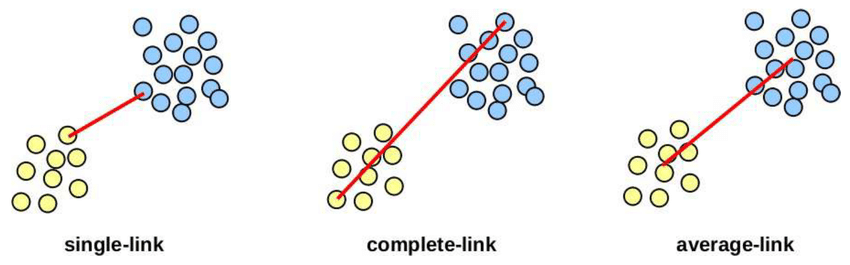


**Key Considerations:**  
- **Strengths:** No need to specify `k`, captures hierarchical relationships.  
- **Limitations:** Computationally expensive, sensitive to linkage type.  
- **Best for:** _Small-to-medium datasets_, exploring cluster hierarchy.  

The y-axis shows the distance bw the clusters at the time of merging.

![Agglomerative Clustering Animation](hierarch.gif)

---

## Key Differences  

| Feature               | k-Means                     | Hierarchical Clustering (Agglomerative) |
|-----------------------|----------------------------|-----------------------------------------|
| **Approach**         | Partition-based, centroid-driven | Hierarchical, distance-driven |
| **Cluster Shape**    | Prefers spherical clusters | Can detect various cluster shapes |
| **Number of Clusters** | Must predefine `k` | Dendrogram can help determine `k` |
| **Scalability**      | Efficient for large datasets | Computationally expensive for large `n` |
| **Result Type**      | Hard assignments | Hierarchical tree (dendrogram) |

---

📌 **When to Use Which?**  
- Use **k-Means** when you need fast, efficient clustering for large datasets with well-separated groups.  
- Use **Hierarchical Clustering** when you want to analyze **cluster relationships** and don't want to predefine `k`.  

In [4]:
from sklearn.metrics import silhouette_samples

def plot_clustering_results(X, labels, centers, silhouette_avg, n_clusters=4):
    """
    Plots the clustering results and the silhouette scores for each sample.

    Parameters:
    X : array-like, shape (n_samples, n_features)
        The input data points.
    labels : array-like, shape (n_samples,)
        The cluster labels for each data point.
    centers : array-like, shape (n_clusters, n_features), optional
        The coordinates of the cluster centers. If None, no centers are plotted.
    silhouette_avg : float
        The average silhouette score for all the samples.
    n_clusters : int, optional, default=4
        The number of clusters.

    Returns:
    None
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

    # Plot the clustering result
    ax1.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')
    if centers is not None:
        ax1.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='X')
    ax1.set_xlabel('Feature 1')
    ax1.set_ylabel('Feature 2')
    ax1.set_title('Clustering Result')

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax2.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax2.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax2.set_title("The silhouette plot for the various clusters.")
    ax2.set_xlabel("The silhouette coefficient values")
    ax2.set_ylabel("Cluster label")

    ax2.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax2.set_yticks([])
    ax2.set_xticks(np.arange(-0.1, 1.1, 0.2))

    plt.show()

## 2. Clustering Algorithms

### 2.1 k-Means Clustering

We will start by implementing k-Means clustering. We will also explore different parameters and visualize the results.

c:\Users\liv_u\Desktop\GitHub\ML-AI\ML-AI\.pixi\envs\default\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Silhouette Score: 0.36794915400160866


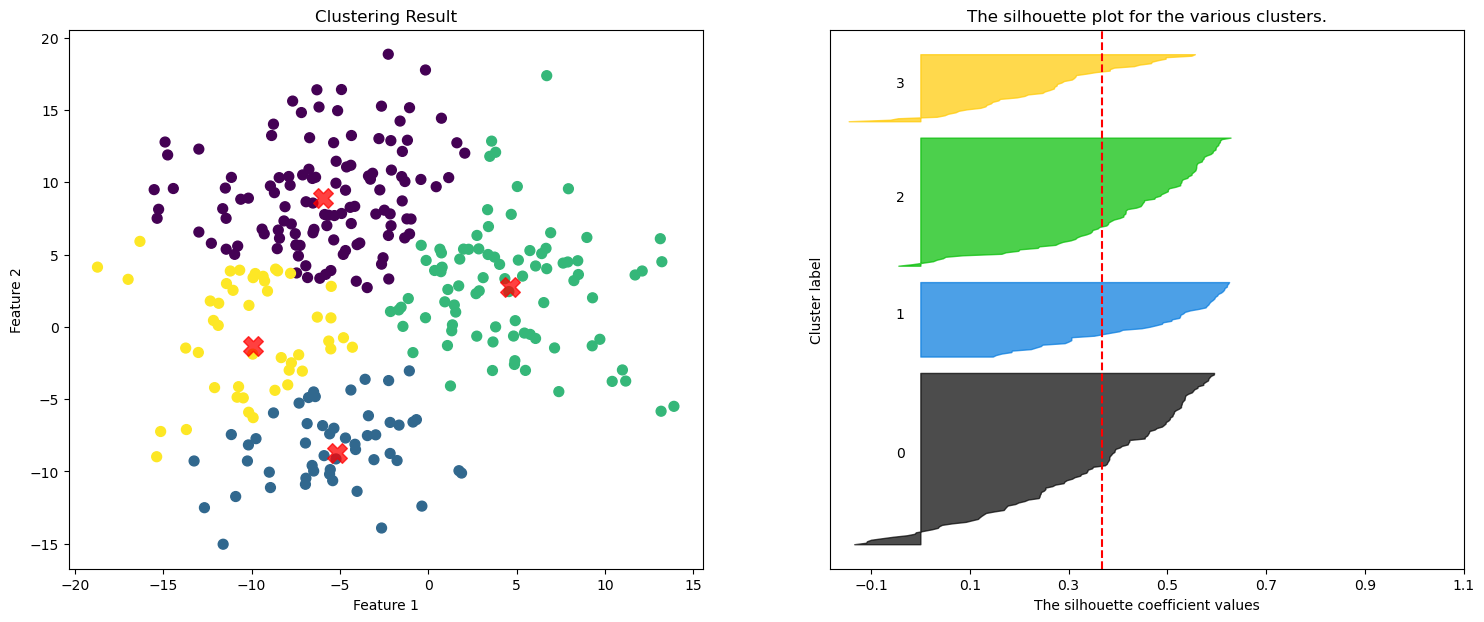

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Generate synthetic data
X, y = make_blobs(n_samples=300, centers=4, cluster_std=4, random_state=42)

# Train a k-Means clustering model
kmeans = KMeans(n_clusters=4, max_iter=5, random_state=42)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

# Evaluate the model
silhouette_avg = silhouette_score(X, y_kmeans)
print(f"Silhouette Score: {silhouette_avg}")

# Plot the clustering results using the custom function
centers = kmeans.cluster_centers_
plot_clustering_results(X, y_kmeans, centers, silhouette_avg, n_clusters=4)


In [ ]:
KMeans?
silhouette_score?

### Questions for Exploration

1. How does changing the number of clusters (`n_clusters`) affect the clustering results?
2. What happens to the silhouette score when you increase `max_iter`?
3. How does the clustering performance change if you use a different random seed for data generation or change the initialization?

### 1.2 Hierarchical Clustering

Next, we will implement hierarchical clustering. We will also explore different parameters and visualize the results.

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import AgglomerativeClustering

# Generate synthetic data
X, y = make_blobs(n_samples=300, centers=4, cluster_std=4, random_state=42)

# Perform agglomerative clustering
Z = linkage(X, 'ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram (Agglomerative)')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

# Train an agglomerative clustering model
agg_clustering = AgglomerativeClustering(n_clusters=4)
y_agg = agg_clustering.fit_predict(X)

# Evaluate the model
silhouette_avg = silhouette_score(X, y_agg)
print(f"Silhouette Score: {silhouette_avg}")

# Plot the clustering results using the custom function
plot_clustering_results(X, y_agg, None, silhouette_avg, n_clusters=4)


In [ ]:
AgglomerativeClustering?
linkage?

### Questions for Exploration

1. How does changing the linkage criterion (e.g., `single`, `complete`, `average`, `centroid`) affect the clustering results?
2. What happens to the silhouette score when you change the number of clusters?
3. How does the clustering performance change if you use a different random seed for data generation?

## 2. Visualization and Interpretation of Clusters

We will visualize and interpret the clusters formed by different clustering algorithms. We will also explore different visualization techniques.

In [ ]:
# Generate synthetic data
X, y = make_blobs(n_samples=300, centers=4, cluster_std=3, random_state=42)

# Train a k-Means clustering model
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

# Perform agglomerative clustering
agg_clustering = AgglomerativeClustering(n_clusters=4)
y_agg = agg_clustering.fit_predict(X)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Plot the k-Means clustering result
ax1.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
ax1.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='X')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
ax1.set_title('k-Means Clustering with Cluster Centers')

# Plot the agglomerative clustering result
ax2.scatter(X[:, 0], X[:, 1], c=y_agg, s=50, cmap='viridis')
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')
ax2.set_title('Agglomerative Clustering')

plt.show()

# print the silhouette scores
silhouette_avg_kmeans = silhouette_score(X, y_kmeans)
silhouette_avg_agg = silhouette_score(X, y_agg)
print(f"Silhouette Score (k-Means): {silhouette_avg_kmeans}")
print(f"Silhouette Score (Agglomerative): {silhouette_avg_agg}")


### Questions for Exploration

1. How do the clusters formed by k-Means and agglomerative clustering compare?
2. Another visualization for clustering discussed in class is the silhouette plot - how does this plot change when you make changes to `cluster_std` in `make_blobs`? 
3. How does the choice of features affect the clustering results and their interpretation?

## 3. Hyperparameter Tuning

We will perform hyperparameter tuning to find the best parameters for each clustering algorithm. We will also explore different evaluation metrics.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grids
param_grid_kmeans = {'n_clusters': [2, 3, 4, 5]} #how many clusters we want to investigate
# can also giev it max iteration dictionary; but more combos you test, longer it takes to compute
param_grid_agg = {'n_clusters': [2, 3, 4, 5], 'linkage': ['ward', 'complete', 'average']} 
# different linkage methods and differnet numbers of clusters

# Perform grid search for agglomerative clustering
def custom_silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    return silhouette_score(X, labels)

# Perform grid search for k-Means
grid_search_kmeans = GridSearchCV(KMeans(random_state=42), param_grid_kmeans, cv=5, scoring=custom_silhouette_scorer)
grid_search_kmeans.fit(X)

grid_search_agg = GridSearchCV(AgglomerativeClustering(), param_grid_agg, cv=5, scoring=custom_silhouette_scorer)
grid_search_agg.fit(X)

# Print best parameters and scores
print(f"Best parameters for k-Means: {grid_search_kmeans.best_params_}")
print(f"Best silhouette score for k-Means: {grid_search_kmeans.best_score_}")

print(f"Best parameters for Agglomerative Clustering: {grid_search_agg.best_params_}")
print(f"Best silhouette score for Agglomerative Clustering: {grid_search_agg.best_score_}")

# made it to have 4 clusters, but best results have 3 clusters 
# --> maximising performance not always best thing, not properly representing underlying data
# want to triage our rare disease states properly, they can be overlooked in this kind of situation 

# but in practice we might not know that there should be 4 clusters


### Questions for Exploration

1. How does hyperparameter tuning improve the performance of each clustering algorithm?
2. What are the best hyperparameters found for each clustering algorithm, and how do they compare to the default parameters?
3. How does the choice of evaluation metric (e.g., silhouette score) impact the results of hyperparameter tuning?

## Extensions

1. Try implementing an elbow plot or gap statistic plot. Does the plot agree with best parameters obtained using `GridSearchCV`?   


## Recall:
### 🔹 Elbow Method  
The **Elbow Plot** helps determine the optimal number of clusters (**k**) by plotting:  
- **X-axis:** Number of clusters (\(k\))  
- **Y-axis:** Within-Cluster Sum of Squares (WCSS)  
        aka 'inertia' from earlier; a way to ID how tightly packerd a cluster is.
        at some point, WCSS might drop dramatically = a good no. to try

#### 🔍 **Interpretation:**  
- **Look for the "elbow"**—the point where the WCSS **stops decreasing sharply**.  
- Before this point, adding clusters significantly reduces WCSS.  
- After this point, diminishing returns indicate that additional clusters provide **little extra benefit**. 


---

### 🔹 Gap Statistic  
The **Gap Statistic Plot** compares the clustering structure in real data to a **randomized reference** distribution. It plots:  
- **X-axis:** Number of clusters (\(k\))  
- **Y-axis:** Gap statistic (higher means better clustering structure)  
        comparing same metric on real data w structure vs dtaa w no structure (eg. TV static)
        --> fitting a model to the real vs to the random.
        heer not looking for sharp decrease but for maximum point

#### 🔍 **Interpretation:**  
- The **optimal \(k\)** is where the **gap statistic is maximized**.  
- If the gap statistic **plateaus** or **starts decreasing**, adding clusters is unnecessary. 
